# Load Libraries and Functions

In [31]:
# System, Data, Time, and Spec Libraries
import os
import pandas as pd
import time
import random
from datetime import datetime, timedelta
import numpy as np 
from line_profiler import LineProfiler  # Code peformance
profiler = LineProfiler()
import warnings
warnings.filterwarnings('ignore')
import csv
#pd.set_option('display.max_colwidth', None)
import multiprocess as mp
num_cores = mp.cpu_count()

# Data Visualization Libraries
import matplotlib.pyplot as plt
from tabulate import tabulate
import plotly.express as px
import seaborn as sns
#from pandas.io.json import json_normalize  # Older version
from pandas import json_normalize  # Newer version
from pandas.plotting import parallel_coordinates
from IPython.display import display, Image
import shap
import streamlit as st


# Natural Language Processing Libraries
import json
import requests
import xml.etree.ElementTree as ET
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import words
import string
import nltk
from collections import OrderedDict
from nltk.tokenize import word_tokenize
from pandas import json_normalize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.util import ngrams
from nltk.corpus import stopwords
from string import punctuation
punctuation = set(punctuation)
punctuation.update({'_', '-','‘'})
english_words = set(words.words())
from fuzzywuzzy import process
#nltk.download('words')
#nltk.download('punkt')
#nltk.download('stopwords')

# SQL Interface Libraries
import pymysql as mysql
import mysql.connector
import pyodbc
import sqlite3
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy import event
from string import punctuation

# Machine Learning Libraries
import scipy.stats as stats
from scipy.stats import zscore
from scipy.stats import yeojohnson
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay,roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, mean_squared_error, f1_score
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from dmba import classificationSummary, AIC_score, BIC_score, plotDecisionTree,gainsChart
from scikitplot.metrics import plot_lift_curve, plot_cumulative_gain
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.metrics import specificity_score, sensitivity_score
from imblearn.under_sampling import RandomUnderSampler
from scikitplot.metrics import plot_lift_curve
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import preprocessing
from sklearn import tree
from sklearn.model_selection import cross_val_score
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
from dmba import stepwise_selection, classificationSummary, backward_elimination
from sklearn.decomposition import PCA
from sklearn.utils.random import sample_without_replacement
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib

# Importing Custom Functions
import nbimporter
from Functions import nan_info, get_model_coefficients_and_odds, evaluate_model

### SQL Password

In [ ]:
PASSWORD  = 'PASSWORD' 

## Investigate number of records in each database table

In [ ]:
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

cursor = connection.cursor()
sql_query = """SELECT COUNT(*) FROM patient_reactions"""


cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]


result_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()

result_query_df

# Get Dataset from SQL Database

In [ ]:
# Connect to the MySQL server
connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

# Create a cursor object
cursor = connection.cursor()

# Query data from SQL

In [ ]:
start_time = time.time()

connection = mysql.connector.connect(
    host="localhost", user="root", password=PASSWORD, database="pharma_db"
)

#temp removed a.expedited,

cursor = connection.cursor()
sql_query = """SELECT 
d.med_product,
d.event_id,
d.manu_num,
a.serious_outcome,
a.age,
a.sex,
a.year,
a.weight,
a.report_source,
r.outcome,
d.ndc9,
p.unit_price
FROM adverse_events a 

INNER JOIN patient_reactions r ON a.event_id = r.event_id
INNER JOIN patient_drugs d ON a.event_id = d.event_id
LEFT JOIN prices p ON d.ndc9 = p.ndc9
ORDER BY a.event_id DESC
"""
cursor.execute(sql_query)
result = cursor.fetchall()
column_names = [i[0] for i in cursor.description]
master_query_df = pd.DataFrame(result, columns=column_names)

cursor.close()
connection.close()


end_time = time.time()
execution_time = end_time - start_time
print(execution_time)



master_query_df = master_query_df.drop_duplicates()


master_query_df['unit_price'] = master_query_df['unit_price'].replace({None: np.nan})

# Calculate the median of the 'unit_price' column, ignoring NaN values
median_unit_price = master_query_df['unit_price'].median()

# Replace NaN values in 'unit_price' with the calculated median
master_query_df['unit_price'] = master_query_df['unit_price'].fillna(median_unit_price)
#master_query_df = master_query_df[master_query_df['expedited'] != 5]

master_query_df.head(10)


master_query_df.to_csv('DataLibrary/result_query_2024_withImputedprices.csv')

In [ ]:

master_query_df.shape

In [ ]:
master_query_df.head()

# Make dataset smaller for testing

In [32]:
master_query_df = pd.read_csv('DataLibrary/result_query_2024_withImputedprices.csv')

# Preparation for Data Split

### Define numerical, text, and categorical variables

In [33]:
cats = ['sex', 'report_source', 'ndc9']
nums = ['weight', 'age', 'unit_price']
all_vars = cats+nums

#Define outcome as categorical
master_query_df['serious_outcome'] = master_query_df['serious_outcome'].astype('category')

master_query_df.head()

,Unnamed: 0,med_product,event_id,manu_num,serious_outcome,age,sex,year,weight,report_source,outcome,ndc9,unit_price
0,0,['xolair'],20885,1,1,25,1,2024,95,3,Unknown,502420040,0.48535
1,4,['xolair'],20885,1,1,25,1,2024,95,3,Recovering,502420040,0.48535
2,14,['xolair'],20885,1,1,25,1,2024,95,3,NotRecovered,502420040,0.48535
3,17,['xolair'],20885,1,1,25,1,2024,95,3,Recovered,502420040,0.48535
4,846,['aspirin'],20885,153,1,25,1,2024,95,3,Unknown,476820456,0.48535


# Split Data into Training/Validation/Testing

In [34]:
master_query_df.shape

(83307, 13)

### Make a Subset of the Dataset for Initial Model Training

In [35]:
# Split the data into features (X) and the target variable (y).
X = master_query_df[all_vars]

#Define outcome variable
y = master_query_df[['serious_outcome']]

#Split data
X_train, X_rest, y_train, y_rest = train_test_split(X, y, train_size=0.8, random_state = 2)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state = 2)

In [36]:
X_train.shape, y_train.shape

((66645, 6), (66645, 1))

In [37]:
y_train.value_counts()

serious_outcome
1                  46637
2                  17317
0                   2691
Name: count, dtype: int64

In [38]:
X_val.shape, y_val.shape

((8331, 6), (8331, 1))

In [39]:
X_test.shape, y_test.shape

((8331, 6), (8331, 1))

In [52]:
X_test.head()

,sex,report_source,ndc9,weight,age,unit_price
13607,2,2,476820456,49,14,0.48535
37526,1,1,837030534,83,71,0.48535
27780,2,3,70300241,68,44,0.48535
73064,2,1,6050504317,36,80,0.48535
51207,1,1,662150501,80,60,0.48535


# Transformation Pipeline

## Encode Categorical Variables (other than drugs) & Standardize Numerical Variables

In [40]:
#Initialize encoders
encoder = OneHotEncoder(drop='if_binary', handle_unknown='ignore')
scaler = StandardScaler()

In [41]:
# Fit the encoder on X so all possible categories are captured, even if they are only in training or testing
encoder.fit(X_train[cats])
scaler.fit(X_train[nums])

StandardScaler()

In [42]:
#Initialize encoders
encoder = OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore')
scaler = StandardScaler()

# Fit the encoder on X so all possible categories are captured, even if they are only in training or testing
encoder.fit(X[cats])
scaler.fit(X_train[nums])


def transform_data(data):
    # Apply one-hot encoding to categorical features
    encoded_features = encoder.transform(data[cats])
    encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cats))
    
    # Apply standardization to numerical features
    standardized_features = scaler.transform(data[nums])
    standardized_df = pd.DataFrame(standardized_features, columns=nums)
    
    # Concatenate the standardized numerical features with the encoded categorical features
    return pd.concat([data.drop(cats + nums, axis=1).reset_index(drop=True),
                      standardized_df.reset_index(drop=True),
                      encoded_df.reset_index(drop=True)], axis=1)

In [43]:
# Apply the transformation to all datasets

# Apply to training data after outcome balancing - need to save raw data components for streamlit
#X_train_encoded = transform_data(X_train) 

X_val_encoded = transform_data(X_val)
X_test_encoded = transform_data(X_test)
X_test_encoded.head()

,weight,age,unit_price,sex_2,report_source_1,report_source_2,report_source_3,ndc9_200152,ndc9_200213,ndc9_202980,...,ndc9_7359409301,ndc9_7467605902,ndc9_7632901912,ndc9_7632903318,ndc9_7632908261,ndc9_7948100090,ndc9_8076200021,ndc9_8215400449,ndc9_8224301001,ndc9_8322200200
0,-1.067765,-2.049919,-0.101208,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.423929,0.785213,-0.101208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.234171,-0.557744,-0.101208,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.638119,1.232865,-0.101208,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.292309,0.238082,-0.101208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Resampling Techniques - UnderSampling of Training Set

In [44]:
y_train.value_counts()

serious_outcome
1                  46637
2                  17317
0                   2691
Name: count, dtype: int64

In [45]:
# Create a RandomUnderSampler instance with a specified random seed and sampling strategy
# Define the sampling strategy to balance all classes
sampling_n = {0: y_train.value_counts()[0], 1: y_train.value_counts()[0], 2: y_train.value_counts()[0]}
rus = RandomUnderSampler(random_state = 1, sampling_strategy=sampling_n )

# Perform random under-sampling on the training dataset
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

In [46]:
X_train_under.shape, y_train_under.shape

((8073, 6), (8073, 1))

In [47]:
y_train_under.value_counts()

serious_outcome
0                  2691
1                  2691
2                  2691
Name: count, dtype: int64

### Save components of raw training data for pretrained model deployment in streamlit

In [49]:
# Create Directory for Model Storage and Apps
os.makedirs('Pretrained_Model_and_Apps', exist_ok=True)

# Initialize and fit the scalers
age_scaler = StandardScaler().fit(X_train_under[['age']])
weight_scaler = StandardScaler().fit(X_train_under[['weight']])
price_scaler = StandardScaler().fit(X_train_under[['unit_price']])

# Save the scalers
joblib.dump(age_scaler, 'Pretrained_Model_and_Apps/age_scaler.joblib')
joblib.dump(weight_scaler, 'Pretrained_Model_and_Apps/weight_scaler.joblib')
joblib.dump(price_scaler, 'Pretrained_Model_and_Apps/price_scaler.joblib')

# Save list of ndc9 codes
ndc9_codes = master_query_df['ndc9'].tolist()
joblib.dump(ndc9_codes, 'Pretrained_Model_and_Apps/ndc9_codes.joblib')

['Pretrained_Model_and_Apps/ndc9_codes.joblib']

### Transform Features of Balanced Dataset

In [50]:
X_train_encoded = transform_data(X_train_under)
X_train_encoded.shape
X_train_encoded.head()

,weight,age,unit_price,sex_2,report_source_1,report_source_2,report_source_3,ndc9_200152,ndc9_200213,ndc9_202980,...,ndc9_7359409301,ndc9_7467605902,ndc9_7632901912,ndc9_7632903318,ndc9_7632908261,ndc9_7948100090,ndc9_8076200021,ndc9_8215400449,ndc9_8224301001,ndc9_8322200200
0,0.950410,0.586256,-0.101208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.248436,-0.309048,-0.101208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.248436,-0.856179,-0.101208,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.520763,-0.607483,-0.101208,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.047244,0.138604,-0.101208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
X_train_under = X_train_encoded

# Multiclass Classification Model Training

## White Box Models

### Logistic Regression L1 Regularization

#### Generate and Fit Model on Training Data

In [ ]:
log_l1 = LogisticRegression(solver='saga', penalty='l1', random_state=1)
log_l1.fit(X_train_under, y_train_under)

#### Fit Model on Testing Data, Model Performance Metrics

In [ ]:
model_name = 'log_l1'

# Run model on test data, generate confusion matrix, save y_pred
log_l1_metrics_df, log_l1_img_path, log_l1_y_pred = evaluate_model(log_l1, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

log_l1_metrics_df.head()

#### Get Probabilities for AUC curve

In [ ]:
log_l1_y_pred_proba = log_l1.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

In [ ]:
display(Image(filename=log_l1_img_path))

#### Other Model Metrics - Model Coefficient Odds for Each Outcome

In [ ]:
coefficients_and_odds = get_model_coefficients_and_odds(X_train_under, log_l1)
for outcome, df in coefficients_and_odds.items():
     print(f"Top features for {outcome}:")
     print(df)

### Logistic Regression L2 Regularization

#### Generate and Fit Model on Training Data

In [ ]:
log_l2 = LogisticRegression(solver='saga', penalty='l2', random_state=1)
log_l2.fit(X_train_under, y_train_under)

#### Fit Model on Testing Data, Model Performance Metrics

In [ ]:
model_name = 'log_l2'

# Run model on test data, generate confusion matrix, save y_pred
log_l2_metrics_df, log_l2_img_path, log_l2_y_pred = evaluate_model(log_l2, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

log_l2_metrics_df.head()

#### Get Probabilities for AUC Curve

In [ ]:
log_l2_y_pred_proba = log_l2.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

In [ ]:
display(Image(filename=log_l2_img_path))

#### Other Metrics - Model Coefficient Odds for Each Outcome

In [ ]:
coefficients_and_odds = get_model_coefficients_and_odds(X_train_under, log_l2)
for outcome, df in coefficients_and_odds.items():
     print(f"Top features for {outcome}:")
     print(df)

### Logistic Regression Elastic Net

#### Grid Search

In [ ]:
param_grid = {
    'l1_ratio': [i / 9 for i in range(10)],  # 10 values from 0 to 1 (0, 0.1, 0.2, ..., 1.0)
    'C': [0.01, 0.1, 1, 10, 100]  # Different strengths of regularization
}

# Initialize the Logistic Regression model with Elastic Net penalty
log_reg_elasticnet = LogisticRegression(
    penalty='elasticnet',  # Use Elastic Net regularization
    solver='saga',        # Solver that supports Elastic Net
    random_state=1
)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=log_reg_elasticnet,
    param_grid=param_grid,
    scoring='accuracy',   # Or another metric of choice
    cv=5,                 # Number of cross-validation folds
    n_jobs=-1              # Use all available CPUs
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_under, y_train_under.values.ravel())

# Extract and print the best parameters and best score from grid search
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

best_score = grid_search.best_score_
print(f"Best cross-validation score: {best_score:.3f}")

# Get the best model
elastic_net = grid_search.best_estimator_


#### Generate and Fit Model on Training Data

In [ ]:
elastic_net.fit(X_train_under, y_train_under)

#### Fit Model on Testing Data, Model Performance Metrics

In [ ]:
model_name = 'elastic_net'

# Run model on test data, generate confusion matrix, save y_pred
elastic_net_metrics_df, elastic_net_img_path, elastic_net_y_pred = evaluate_model(elastic_net, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

elastic_net_metrics_df.head()

#### Get Probabilities for AUC

In [ ]:
elastic_net_y_pred_proba = elastic_net.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

In [ ]:
display(Image(filename=elastic_net_img_path))

#### Other Metrics - Model Coefficient Odds for Each Outcome

In [ ]:
coefficients_and_odds = get_model_coefficients_and_odds(X_train_under, elastic_net)
for outcome, df in coefficients_and_odds.items():
     print(f"Top features for {outcome}:")
     print(df)

### Single Decision Tree

#### Grid Search

In [ ]:
# Define a grid of hyperparameters to search for in tree
param_grid = {
    'max_depth' : [5,6,7,8,9,10],
    'min_samples_leaf' : [1,2,3,4,5,6]
    
}
# Create a GridSearchCV object using and the defined parameter grid
tree1_search = GridSearchCV(DecisionTreeClassifier(random_state=1), param_grid, cv=10, n_jobs=-1)

# Fit the GridSearchCV to the balanced training data to find the best hyperparameters
tree1_search.fit(X_train_under, y_train_under.values.ravel())

# Get the best hyperparameters found by the GridSearch
best_params = tree1_search.best_params_
print(f"Best parameters: {best_params}")

tree1 = tree1_search.best_estimator_


#### Generate and Fit Model on Training Data

In [ ]:
tree1.fit(X_train_under, y_train_under)

#### Fit Model on Testing Data, Model Performance Metrics

In [ ]:
model_name = 'tree1'

# Run model on test data, generate confusion matrix, save y_pred
tree1_metrics_df, tree1_img_path, tree1_y_pred = evaluate_model(tree1, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

tree1_metrics_df.head()

#### Get Probabilities for AUC

In [ ]:
tree1_y_pred_proba = tree1.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

In [ ]:
display(Image(filename=tree1_img_path))

#### Other Metrics - Feature Importance and Tree Structure

In [ ]:
# Feature Importance Scores
# Extract feature importances
importances = tree1.feature_importances_
features = X_train_under.columns

# Create a DataFrame for better plotting
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 8))
bars = plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot for DecisionTreeClassifier')
plt.gca().invert_yaxis()  # To display the most important feature at the top
# Add labels to the bars
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f'{bar.get_width():.4f}',
        va='center'
    )

plt.show()

In [ ]:
from sklearn.tree import plot_tree
# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(tree1, filled=True, feature_names=X_train_under.columns, class_names=['NonSerious', 'Serious', 'Death'], rounded=True)
plt.title('Decision Tree Structure')
plt.show()

In [ ]:
#Plot max_depth = 2
from sklearn.tree import plot_tree
folder_path = 'ModelOutput'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
img_path = os.path.join(folder_path, 'tree1_maxdepth2.png')

# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(tree1, filled=True,max_depth=2, feature_names=X_train_under.columns, class_names=['NonSerious', 'Serious', 'Death'], rounded=True)
plt.title('Decision Tree Structure')
plt.show()
plt.savefig(img_path)

In [ ]:
#Plot max_depth = 1
from sklearn.tree import plot_tree
folder_path = 'ModelOutput'
if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
img_path = os.path.join(folder_path, 'tree1_maxdepth1.png')

# Plot the tree structure
plt.figure(figsize=(20, 10))
plot_tree(tree1, filled=True,max_depth=1, feature_names=X_train_under.columns, class_names=['NonSerious', 'Serious', 'Death'], rounded=True)
plt.title('Decision Tree Structure')
plt.show()
plt.savefig(img_path)

## Ensembles

### Random Forest Classifier w/ 5-k CV

#### Grid Search

In [53]:
start_time = time.time()


param_grid = {
    'n_estimators': [100, 125, 150, 175, 200]  # Example range for number of estimators
}

# Initialize the Random Forest Classifier
random_forest = RandomForestClassifier(random_state=1)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=random_forest,
                           param_grid=param_grid,
                           cv=5,  # Number of cross-validation folds
                           scoring='accuracy',  # Use accuracy as the scoring metric
                           n_jobs=-1,  # Use all available cores
                           verbose=2)  # Print progress messages

# Fit GridSearchCV to the data
grid_search.fit(X_train_under, y_train_under.values.ravel())

# Get the best model from the grid search
rf = grid_search.best_estimator_

rf.fit(X_train_under, y_train_under)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Example: Printing the best model parameters
print("Best Random Forest Model:")
print(rf)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'n_estimators': 125}
Best Score: 0.8233611472372162
Best Random Forest Model:
RandomForestClassifier(n_estimators=125, random_state=1)
116.34193205833435


#### Fit Model on Testing Data, Model Performance Metrics

In [54]:
model_name = 'rf'

# Run model on test data, generate confusion matrix, save y_pred
rf_metrics_df, rf_img_path, rf_y_pred = evaluate_model(rf, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

rf_metrics_df.head()

,model,class,accuracy,precision,recall,f1_score,specificity
0,rf,0,0.807,0.416,0.909,0.571,0.996
1,rf,1,0.807,0.922,0.799,0.857,0.642
2,rf,2,0.807,0.692,0.811,0.747,0.930


In [70]:
X_test.iloc[4:10,:]

,sex,report_source,ndc9,weight,age,unit_price
51207,1,1,662150501,80,60,0.48535
46366,2,1,2405911,86,62,0.48535
34475,2,3,690760105,54,36,0.48491
79608,2,1,592120562,97,44,0.48535
35561,1,1,423880023,72,62,0.48535
77614,2,3,45601201,61,72,0.48535


In [71]:
X_test_encoded.iloc[4:10,:]

,weight,age,unit_price,sex_2,report_source_1,report_source_2,report_source_3,ndc9_200152,ndc9_200213,ndc9_202980,...,ndc9_7359409301,ndc9_7467605902,ndc9_7632901912,ndc9_7632903318,ndc9_7632908261,ndc9_7948100090,ndc9_8076200021,ndc9_8215400449,ndc9_8224301001,ndc9_8322200200
4,0.292309,0.238082,-0.101208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.555550,0.337560,-0.101208,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,-0.848398,-0.955657,-0.101208,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.038157,-0.557744,-0.101208,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,-0.058678,0.337560,-0.101208,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,-0.541285,0.834952,-0.101208,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
rf_y_preds = rf.predict(X_test_encoded.iloc[4:10,:])
rf_y_preds

array([1, 0, 1, 2, 0, 2], dtype=int64)

In [73]:
y_test.iloc[4:10,:]

,serious_outcome
51207,1
46366,0
34475,1
79608,2
35561,0
77614,2


#### Get Probabilities for AUC

In [ ]:
rf_y_pred_proba = rf.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

In [ ]:
display(Image(filename=rf_img_path))

#### Other Metrics - Top 5 Feature Importance

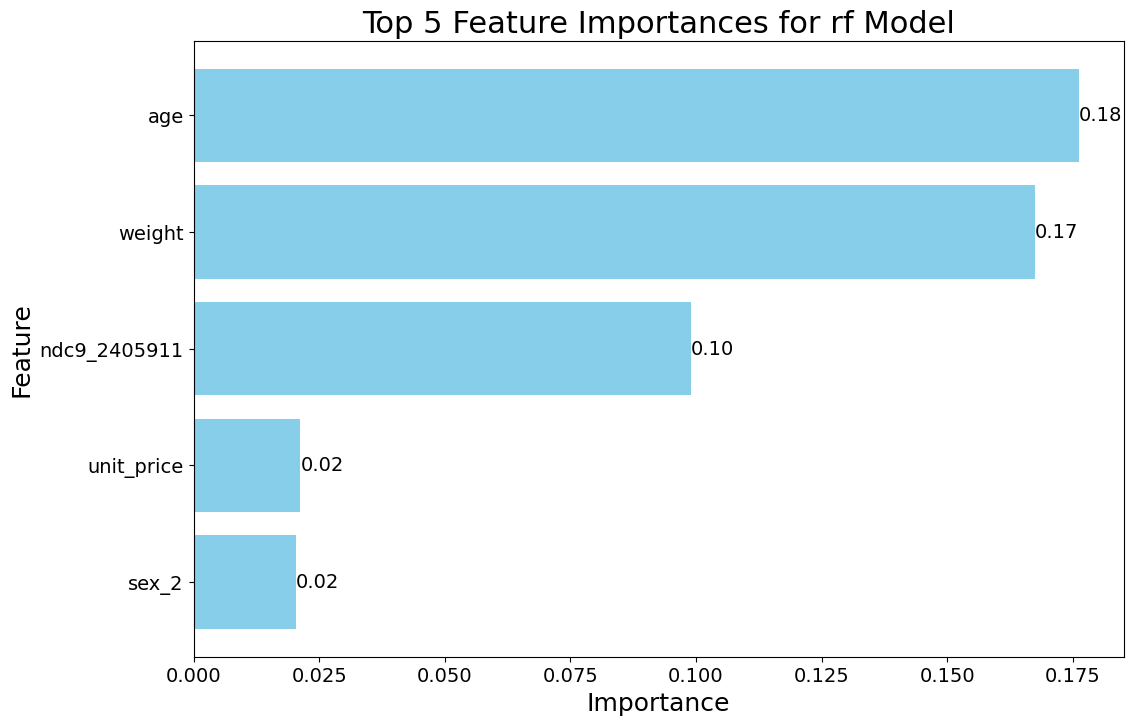

In [55]:
%matplotlib inline

# Get the feature importances
importances = rf.feature_importances_

# Get the feature names
feature_names = X_train_encoded.columns

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Select the top 5 features
top_n = 5
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_feature_names = feature_names[top_indices]

# Plot the top 5 feature importances
plt.figure(figsize=(12, 8))  # Increased figure size for better readability
bars = plt.barh(top_feature_names, top_importances, color='skyblue', align='center')

# Add data labels
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}', 
             va='center', ha='left', color='black', fontsize=14)

# Customize plot appearance
plt.title('Top 5 Feature Importances for rf Model', fontsize=22)
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)
plt.gca().invert_yaxis()  # To display the highest importance at the top

# Set tick labels font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()

#### Top 10 Feature Importance

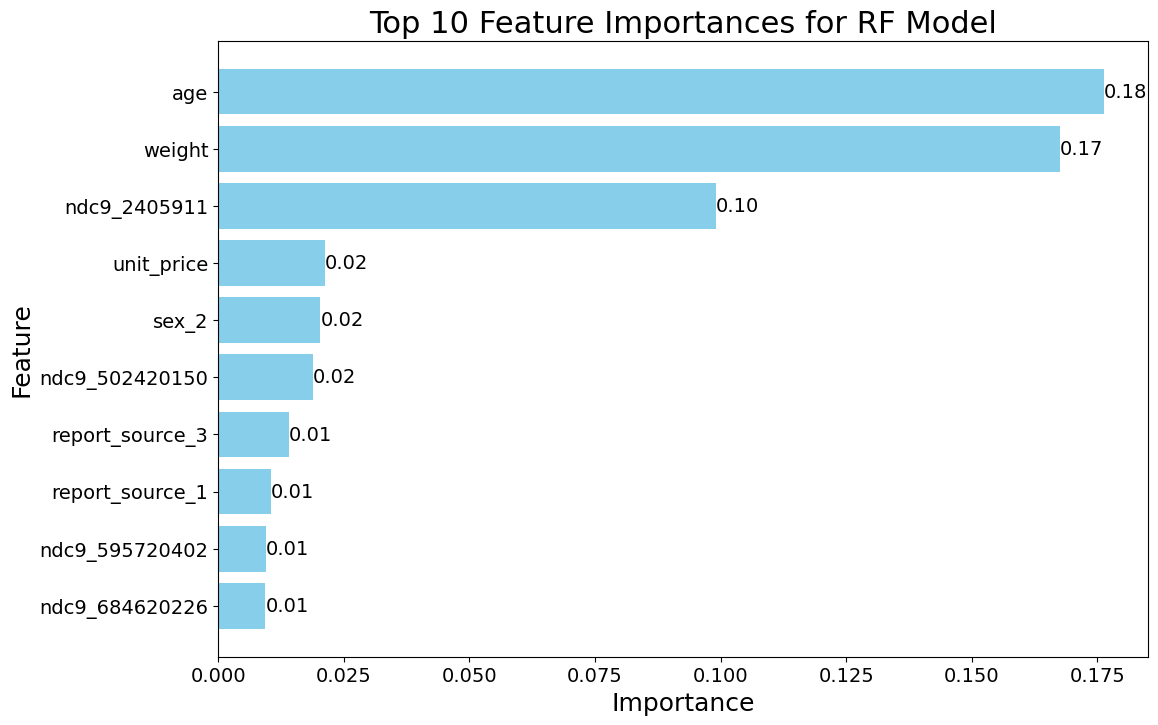

In [57]:
%matplotlib inline

# Get the feature importances
importances = rf.feature_importances_

# Get the feature names
feature_names = X_train_encoded.columns

# Sort the feature importances in descending order
indices = np.argsort(importances)[::-1]

# Select the top 5 features
top_n = 10
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_feature_names = feature_names[top_indices]

# Plot the top 5 feature importances
plt.figure(figsize=(12, 8))  # Increased figure size for better readability
bars = plt.barh(top_feature_names, top_importances, color='skyblue', align='center')

# Add data labels
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.2f}', 
             va='center', ha='left', color='black', fontsize=14)

# Customize plot appearance
plt.title('Top 10 Feature Importances for RF Model', fontsize=22)
plt.xlabel('Importance', fontsize=18)
plt.ylabel('Feature', fontsize=18)
plt.gca().invert_yaxis()  # To display the highest importance at the top

# Set tick labels font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()

#### Save Pretrained Model using joblib

In [ ]:
# Save the model to the new directory
joblib.dump(rf, 'Pretrained_Model_and_Apps/rf.joblib')

#### Shapley Additive Explanations Plot

In [ ]:
start_time = time.time()

# Load the data and model
model = joblib.load('Pretrained_Model_and_Apps/rf.joblib')

# Sample a smaller portion of the data
sample_size = 1000  # Adjust sample size to a smaller number if needed
X_sample = X_train_under[['age', 'sex_2', 'weight', 'unit_price']].sample(n=sample_size, random_state=42)

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(model)

# Compute SHAP values
shap_values = explainer.shap_values(X_sample)

# Summary plot for each class
for i in range(len(shap_values)):
    plt.figure()
    shap.summary_plot(shap_values[i], X_sample, plot_type="bar", class_names=['Nonserious', 'Serious', 'Death'])
    #plt.savefig(f'shap_summary_class_{i}.png')  # Save the plot as an image file
    plt.show()
    #plt.close()

# Compute mean absolute SHAP values across all classes
mean_abs_shap_values = np.mean([np.abs(shap_values[i]) for i in range(len(shap_values))], axis=0)

# Generate a combined summary plot
plt.figure()
shap.summary_plot(mean_abs_shap_values, X_sample, plot_type="bar")
plt.show()
#plt.savefig('shap_combined_summary.png')  # Save the combined summary plot as an image file
#plt.close()

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

### Gradient Boosted Tree w/ 10-k CV

#### Grid Search

In [ ]:
start_time = time.time()

# Define a grid of hyperparameters to search for in the Gradient Boosting Classifier
param_grid = {
    'max_depth' : [5,6,7,8,9,10],
    'learning_rate' : [0.0001, 0.001, 0.01, 0.1, 1],
    'n_estimators' : [50,75,100,125,150],
}
# Create a GridSearchCV object using GradientBoostingClassifier and the defined parameter grid
tree_search = GridSearchCV(GradientBoostingClassifier(random_state=1), param_grid, cv=10, n_jobs=-1)
# Fit the GridSearchCV to the balanced training data to find the best hyperparameters
tree_search.fit(X_train_under, y_train_under.values.ravel())
# Get the best hyperparameters found by the GridSearch
tree_search.best_params_

grboost = tree_search.best_estimator_


# Print the best parameters and the best score
print("Best Parameters:", tree_search.best_params_)
print("Best Score:", tree_search.best_score_)

# Example: Printing the best model parameters
print("Best Gradient Boosted Tree:")
print(grboost)

end_time = time.time()
execution_time = end_time - start_time
print(execution_time)

#### Fit Model on Testing Data, Model Performance Metrics

In [ ]:
model_name = 'grboost'

# Run model on test data, generate confusion matrix, save y_pred
grboost_metrics_df, grboost_img_path, grboost_y_pred = evaluate_model(grboost, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

grboost_metrics_df.head()

#### Get probabilities for AUC

In [ ]:
grboost_y_pred_proba = grboost.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

In [ ]:
display(Image(filename=grboost_img_path))

#### Other Metrics

In [ ]:
# Get feature importance scores
importances=rf.feature_importances_
feature_importance_pairs=list(zip(X_train_under.columns, importances))

# Sort in descending order
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Print scores
print("Feature Importance Scores")
for feature, importance in sorted_feature_importance_pairs:
     print(f"{feature}: {importance:.4f}")

## Non-parametric

### K-Nearest Neighbors Classifier

#### Grid Search

In [ ]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]  # Example range for number of neighbors
}

# Initialize the K-Nearest Neighbors Classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search_knn = GridSearchCV(estimator=knn,
                               param_grid=param_grid,
                               cv=5,  # Number of cross-validation folds
                               scoring='accuracy',  # Use accuracy as the scoring metric
                               n_jobs=-1,  # Use all available cores
                               verbose=2)  # Print progress messages

# Fit GridSearchCV to the data
grid_search_knn.fit(X_train_under, y_train_under.values.ravel())

# Get the best model from the grid search
knn = grid_search_knn.best_estimator_

# Print the best parameters and the best score
print("Best Parameters for KNN:", grid_search_knn.best_params_)
print("Best Score for KNN:", grid_search_knn.best_score_)

# Example: Printing the best model parameters
print("Best KNN Model:")
print(knn)

#### Fit Model on Testing Data, Model Performance Metrics

In [ ]:
model_name = 'knn'

# Run model on test data, generate confusion matrix, save y_pred
knn_metrics_df, knn_img_path, knn_y_pred = evaluate_model(knn, X_test_encoded, y_test, labels=[0, 1, 2], model_name=model_name)

knn_metrics_df.head()

#### Get Probabilities for AUC

In [ ]:
knn_y_pred_proba = knn.predict_proba(X_test_encoded)  # This should be a 2D array

#### View Classification Matrix

In [ ]:
display(Image(filename=knn_img_path))

#### Other Metrics

### Baseline

In [ ]:
from sklearn.dummy import DummyClassifier

baseline_model = DummyClassifier(strategy='most_frequent')
baseline_model.fit(X_test_encoded, y_test)
baseline_metrics_df, baseline_img_path, _ = evaluate_model(
    baseline_model, X_test_encoded, y_test, labels=[0, 1, 2], model_name='Baseline'
)
baseline_metrics_df

# Performance Metrics Table

In [ ]:
def display_model_metrics_table(metrics_dfs):
    # Concatenate all DataFrames
    combined_df = pd.concat(metrics_dfs, ignore_index=True)
    
    # Convert DataFrame to a list of lists for tabulate
    table = combined_df.values.tolist()
    
    # Get column headers from DataFrame
    headers = combined_df.columns.tolist()
    
    # Generate and print the table
    table_str = tabulate(table, headers, tablefmt='pretty')
    print(table_str)
    return combined_df

model_metrics = display_model_metrics_table([baseline_metrics_df,log_l1_metrics_df, log_l2_metrics_df, elastic_net_metrics_df,
                           tree1_metrics_df, rf_metrics_df, knn_metrics_df, grboost_metrics_df])  # grboost_metrics_df

### Show Class Outcomes more Cleanly for Paper

Saves as csv, that can copy paste into the Excel file within the same folder. This makes it easy to paste the values into the paper

In [ ]:

def format_as_percentage(df):
    # Format metrics as percentage with one decimal point
 #   df['accuracy'] = df['accuracy'].apply(lambda x: f"{x * 100:.1f}%")
    df['precision'] = df['precision'].apply(lambda x: f"{x * 100:.1f}%")
    df['recall'] = df['recall'].apply(lambda x: f"{x * 100:.1f}%")
    df['specificity'] = df['specificity'].apply(lambda x: f"{x * 100:.1f}%")
    df['f1_score'] = df['f1_score'].apply(lambda x: f"{x * 100:.1f}%")
    return df

model_metrics = format_as_percentage(model_metrics)

def aggregate_metrics(df):
    # Group by 'model'
    grouped = df.groupby('model').agg({
        'accuracy': 'mean',  # Average accuracy
        'precision': lambda x: x.tolist(),  # List of precision values
        'recall': lambda x: x.tolist(),  # List of recall values
        'specificity': lambda x: x.tolist(),  # List of specificity values
        'f1_score': lambda x: x.tolist()  # List of F1 scores
    }).reset_index()
    
    return grouped

# Apply aggregation function
aggregated_df = aggregate_metrics(model_metrics)




# Rename columns
aggregated_df = aggregated_df.rename(columns={
  #  'model': 'Model',
    'accuracy': 'Accuracy',
    'precision': 'Precision (class 0,1,2)',
    'recall': 'Recall (class 0,1,2)',
    'f1_score': 'F-score (class 0,1,2)',
    'specificity': 'Specificity (class 0,1,2)'
})


# Rename values in 'model' column
aggregated_df['model'] = aggregated_df['model'].replace({
    'elastic_net': 'Elastic Net',
    'knn': 'KNN',
    'tree1': 'Decision Tree',
    'log_l1': 'Lasso Regression',
    'log_l2': 'Ridge Regression',
    'rf': 'Random Forest',
    'grboost': 'Gradient Boosted Decision Tree'
    
})

aggregated_df['Accuracy'] = aggregated_df['Accuracy'] .apply(lambda x: f"{x * 100:.1f}%")

# Display the resulting DataFrame
print(aggregated_df)

#Save it as a CSV
folder_path = 'ModelOutput\withPrices'
os.makedirs(folder_path, exist_ok=True)
file_path = os.path.join(folder_path, 'aggregated_metrics_withpricesImputed.csv')
aggregated_df.to_csv(file_path, index=False)


### AUC Curves

In [ ]:
# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# List of model names
model_names = ['Gradient Boost Decision Tree', 'Elastic Net', 'Lasso Regression', 'Ridge Regression', 'Single Decision Tree', 'Random Forest', 'KNN']

# List of true labels and predicted probabilities
y_tests = [y_test, y_test, y_test, y_test, y_test, y_test, y_test]  # True labels for each model
y_pred_probs = [grboost_y_pred_proba, elastic_net_y_pred_proba, log_l1_y_pred_proba, log_l2_y_pred_proba, tree1_y_pred_proba, rf_y_pred_proba, knn_y_pred_proba]  # Predicted probabilities for each model

# Colors for each model
colors = {
    'Gradient Boost Decision Tree': 'blue',
    'Elastic Net': 'darkgreen',
    'Lasso Regression': 'red',
    'Ridge Regression': 'purple',
    'Single Decision Tree': 'orange',
    'Random Forest': 'lime',  # Distinct color for Random Forest
    'KNN': 'magenta'
}

# Number of classes
n_classes = 3

# Binarize the output labels for each class
y_tests_bin = [label_binarize(y, classes=range(n_classes)) for y in y_tests]

plt.figure(figsize=(12, 10))

# Class to focus on
class_index = 2

for model_name, y_test_bin, y_pred_prob in zip(model_names, y_tests_bin, y_pred_probs):
    # Compute ROC curve and ROC area for the specific class
    fpr, tpr, _ = roc_curve(y_test_bin[:, class_index], y_pred_prob[:, class_index])
    roc_auc = auc(fpr, tpr)
    
    # Set line width and color based on model
    if model_name == 'Random Forest':
        lw = 4  # Thicker line for Random Forest
        color = colors.get(model_name, 'black')  # Color for Random Forest
    else:
        lw = 2  # Default line width
        color = colors.get(model_name, 'black')  # Default color for other models

    # Plot ROC curve for the specific class
    plt.plot(fpr, tpr, lw=lw, color=color, label=f'{model_name} (class {class_index}) AUC = {roc_auc:.2f}')

# Plot random guess line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Set axis labels and title with font sizes
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic (ROC) for Class 2', fontsize=20)

# Adjust the size of the axis ticks and legend
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc="lower right", fontsize=16)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

folder_path = 'ModelOutput\withPrices'
img_path = os.path.join(folder_path, 'ROCPlotImputation.png')
plt.savefig(img_path)

plt.show()


# Top Model Performance on Validation Data

In [ ]:
y_val

In [ ]:
model_name = 'rf'

# Run model on test data, generate confusion matrix, save y_pred
rf_metrics_df_val, rf_img_path_val, rf_y_pred_val = evaluate_model(rf, X_val_encoded, y_val, labels=[0, 1, 2], model_name=model_name)

rf_metrics_df_val.head()

In [ ]:
rf

In [ ]:
X_test_encoded